In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Reshape, Input
from tensorflow.keras.regularizers import L1L2

In [2]:
(X_train, _), (_, _) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
X_train = X_train.astype('float32') / 255

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=600000).batch(batch_size=156)

In [6]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None)>

In [7]:
# Gerador
generator = Sequential()

generator.add(Input(shape=(100,)))
generator.add(Dense(units=500, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
generator.add(Dense(units=500, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
generator.add(Dense(units=784, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))

generator.add(Reshape((28, 28)))

generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 500)                 │          50,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 784)                 │         392,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,784 (2.65 MB)

 Trainable params: 693,784 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
discriminator = Sequential()

discriminator.add(InputLayer(shape=(28, 28)))

discriminator.add(Flatten())

discriminator.add(Dense(units=500, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
discriminator.add(Dense(units=500, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))

discriminator.add(Dense(units=1, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)))

discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 500)                 │         392,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             501 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 643,501 (2.45 MB)

 Trainable params: 643,501 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [10]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    return real_loss + fake_loss

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [13]:
epochs = 100
noise_dim = 100

In [14]:
def train_step(imagens):
    noise = tf.random.normal([256, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(imagens, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [15]:
for epoch in range(epochs):
    for image_batch in X_train:
        gen_loss_batch, disc_loss_batch = train_step(image_batch)
    print(f'Época {epoch} | gen_loss: {gen_loss_batch} disc_loss {disc_loss_batch}')

Época 0 | gen_loss: 5.593462944030762 disc_loss 0.05585332587361336
Época 1 | gen_loss: 6.205642223358154 disc_loss 0.012256802059710026
Época 2 | gen_loss: 4.514848709106445 disc_loss 0.03015938773751259
Época 3 | gen_loss: 3.857405185699463 disc_loss 0.05879785865545273
Época 4 | gen_loss: 5.970115661621094 disc_loss 0.006780067924410105
Época 5 | gen_loss: 7.363197326660156 disc_loss 0.005089571699500084
Época 6 | gen_loss: 7.8759660720825195 disc_loss 0.011768664233386517
Época 7 | gen_loss: 7.323769569396973 disc_loss 0.003943772055208683
Época 8 | gen_loss: 6.761552810668945 disc_loss 0.005206781905144453
Época 9 | gen_loss: 7.009979248046875 disc_loss 0.0021290669683367014
Época 10 | gen_loss: 10.309452056884766 disc_loss 0.0011683134362101555
Época 11 | gen_loss: 8.459646224975586 disc_loss 0.0015389982145279646
Época 12 | gen_loss: 6.7425432205200195 disc_loss 0.014838979579508305
Época 13 | gen_loss: 8.274467468261719 disc_loss 0.0010218066163361073
Época 14 | gen_loss: 8.292

In [17]:
samples = np.random.normal(size=(20, 100))
prevs = generator.predict(samples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


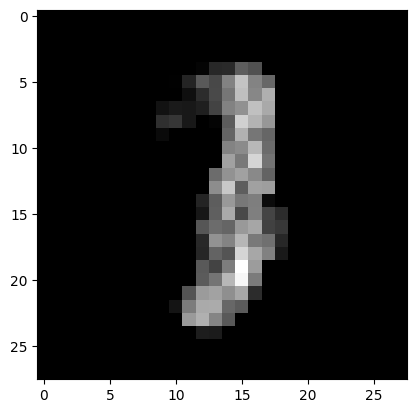

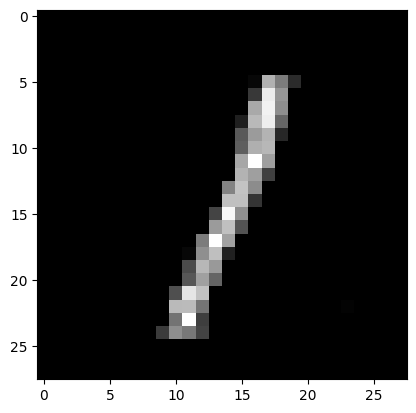

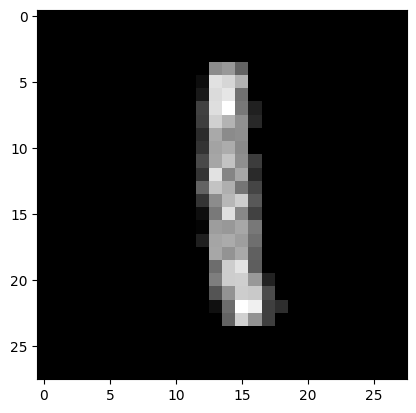

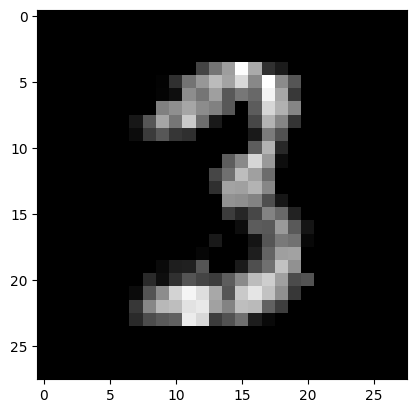

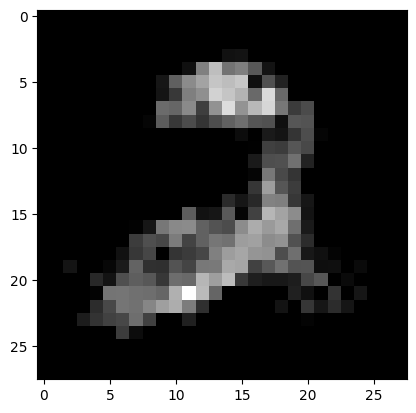

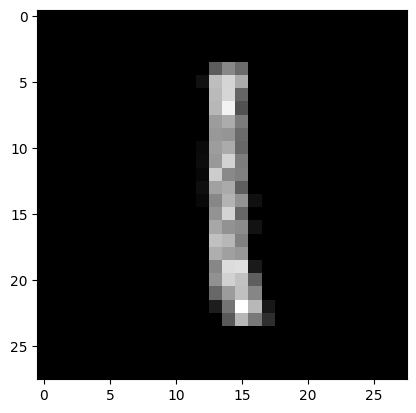

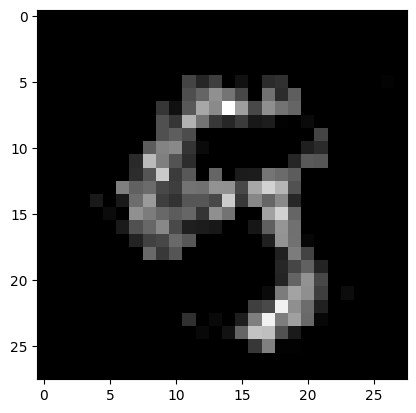

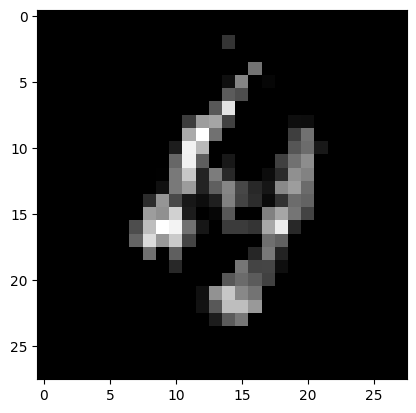

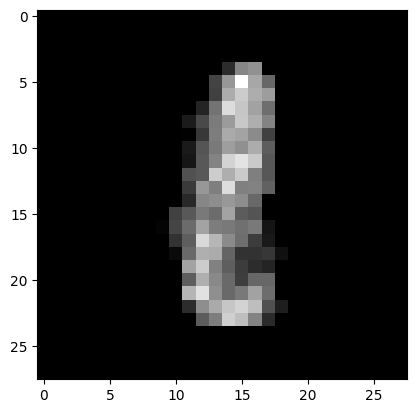

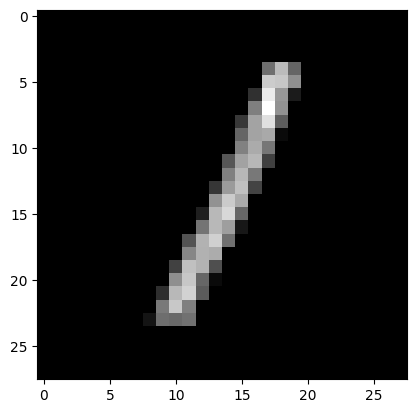

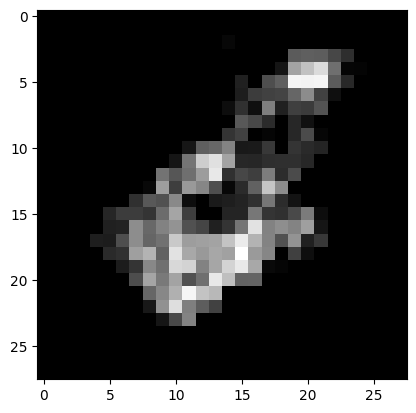

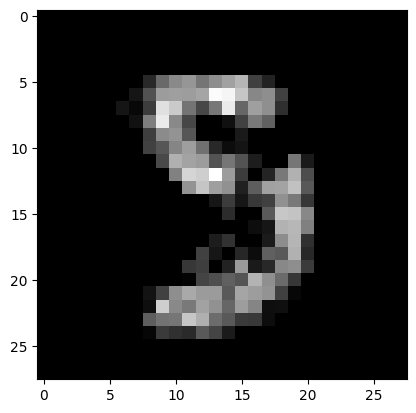

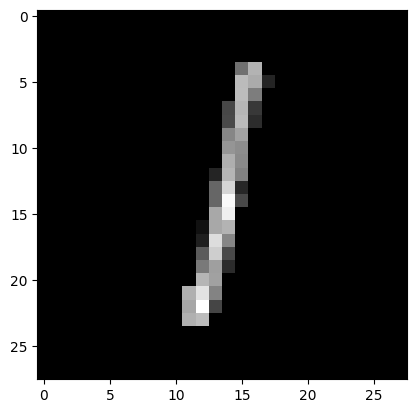

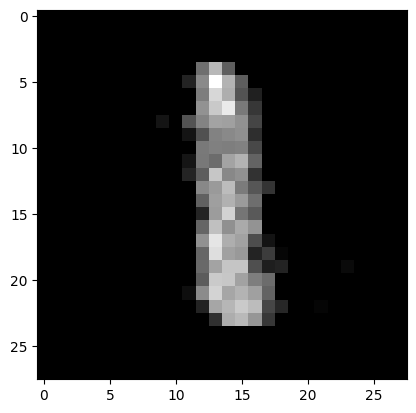

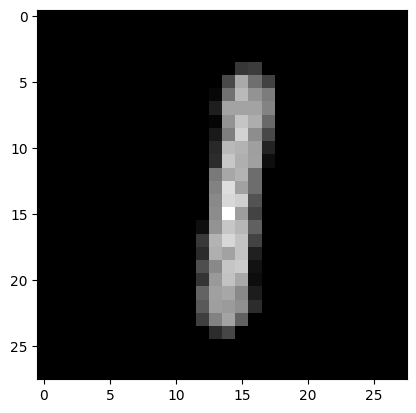

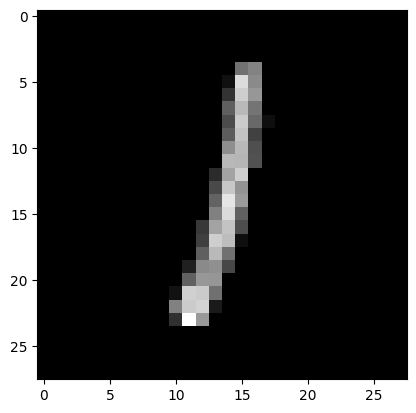

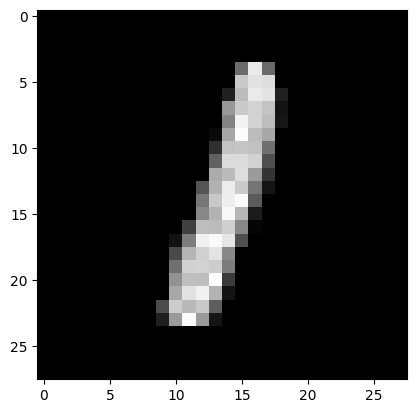

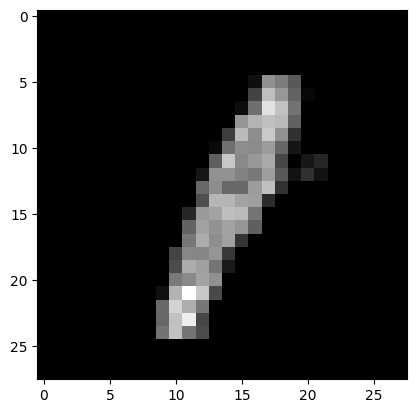

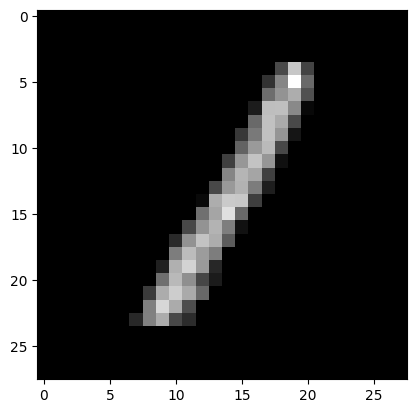

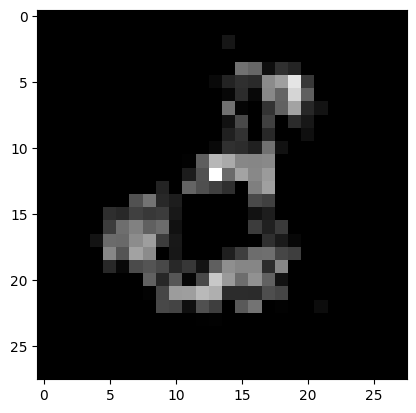

In [18]:
for i in range(prevs.shape[0]):
    plt.imshow(prevs[i, :], cmap='gray')
    plt.show()